### Pipeline

In [1]:
import boto3
import pandas as pd
import numpy as np
import psycopg2
import mysql.connector as mysql
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import configparser

In [2]:
config = configparser.ConfigParser()
config.read('config.cfg')

['config.cfg']

In [3]:
aws_rds_conn = boto3.client('rds', aws_access_key_id=config.get('IAM','ACCESS_KEY'), 
                              aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'), 
                              region_name='us-east-1')

In [4]:
rds_instances_ids = []

aws_response = aws_rds_conn.describe_db_instances()

for response in aws_response['DBInstances']:
    rds_instances_ids.append(response['DBInstanceIdentifier'])

print(f'Instancias Disponibles" {rds_instances_ids}')

Instancias Disponibles" ['banco-transactional', 'ventas-dwh', 'ventas-transactional']


In [7]:
try:
    response = aws_rds_conn.create_db_instance(
                DBInstanceIdentifier=config.get('TRANSACC','DB_INSTANCE_ID'),
                DBName=config.get('TRANSACC', 'DB_NAME'),
                DBInstanceClass='db.t3.micro',
                Engine='mysql',
                MasterUsername=config.get('TRANSACC', 'DB_USER'),
                MasterUserPassword=config.get('TRANSACC', 'DB_PASSWORD'),
                Port=int(config.get('TRANSACC', 'DB_PORT')),
                PubliclyAccessible=True,
                VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
                AllocatedStorage=15
               )
    print(response)
except aws_rds_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print('La instancia ya existe')
except Exception as ex:
    print('Error!! ', ex)
    

{'DBInstance': {'DBInstanceIdentifier': 'ventas-transactional', 'DBInstanceClass': 'db.t3.micro', 'Engine': 'mysql', 'DBInstanceStatus': 'creating', 'MasterUsername': 'mysql_admin', 'DBName': 'puntoventa', 'AllocatedStorage': 15, 'PreferredBackupWindow': '06:08-06:38', 'BackupRetentionPeriod': 1, 'DBSecurityGroups': [], 'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-011f0a6c313f819e9', 'Status': 'active'}], 'DBParameterGroups': [{'DBParameterGroupName': 'default.mysql8.0', 'ParameterApplyStatus': 'in-sync'}], 'DBSubnetGroup': {'DBSubnetGroupName': 'default', 'DBSubnetGroupDescription': 'default', 'VpcId': 'vpc-09e5ac0049f317462', 'SubnetGroupStatus': 'Complete', 'Subnets': [{'SubnetIdentifier': 'subnet-002e032543a6bab3c', 'SubnetAvailabilityZone': {'Name': 'us-east-1f'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-075dee9f0bf4b8e81', 'SubnetAvailabilityZone': {'Name': 'us-east-1b'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 

In [6]:
try:
    instance=aws_rds_conn.describe_db_instances(DBInstanceIdentifier=config.get('TRANSACC','DB_INSTANCE_ID'))
    RDS_HOSTNAME= instance.get('DBInstances')[0].get('Endpoint').get('Address')
    print(RDS_HOSTNAME)
except Exception as ex:
    print('Error!!!', ex)

ventas-transactional.crkusmo6c5dz.us-east-1.rds.amazonaws.com


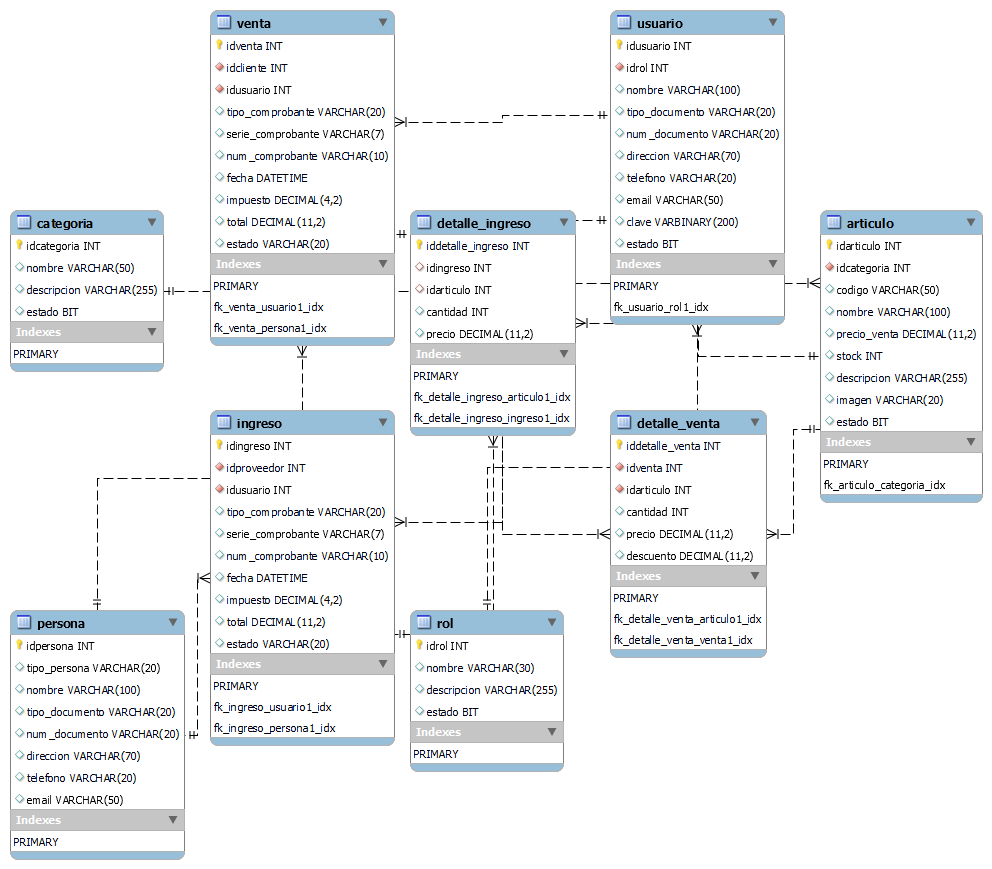

In [24]:
import Querys
Querys.DDL_QUERY

'\nCREATE TABLE IF NOT EXISTS categoria (\n  idcategoria INT NOT NULL,\n  nombre VARCHAR(50) NULL,\n  descripcion VARCHAR(255) NULL,\n  estado BIT NULL,\n  PRIMARY KEY (idcategoria)\n  );\n\n\nCREATE TABLE IF NOT EXISTS articulo (\n  idarticulo INT NOT NULL,\n  idcategoria INT NOT NULL,\n  codigo VARCHAR(50) NULL,\n  nombre VARCHAR(100) NULL,\n  precio_venta DECIMAL(11,2) NULL,\n  stock INT NULL,\n  descripcion VARCHAR(255) NULL,\n  imagen VARCHAR(20) NULL,\n  estado BIT NULL,\n  PRIMARY KEY (idarticulo),\n  INDEX fk_articulo_categoria_idx (idcategoria) ,\n  \n  CONSTRAINT fk_articulo_categoria\n    FOREIGN KEY (idcategoria)\n    REFERENCES categoria (idcategoria)\n    );\n\n\nCREATE TABLE IF NOT EXISTS rol (\n  idrol INT NOT NULL,\n  nombre VARCHAR(30) NULL,\n  descripcion VARCHAR(255) NULL,\n  estado BIT NULL,\n  PRIMARY KEY (idrol)\n  );\n\n\nCREATE TABLE IF NOT EXISTS usuario (\n  idusuario INT NOT NULL,\n  idrol INT NOT NULL,\n  nombre VARCHAR(100) NULL,\n  tipo_documento VARCHAR(

In [25]:
try:
    db_my_conn = mysql.connect(
                    user=config.get('TRANSACC', 'DB_USER'),
                    password=config.get('TRANSACC', 'DB_PASSWORD'),
                    database=config.get('TRANSACC', 'DB_NAME'),
                    host=RDS_HOSTNAME,
                    port=config.get('TRANSACC', 'DB_PORT')
                )
    cursor = db_my_conn.cursor()
    cursor.execute(Querys.DDL_QUERY)
    print("Base de datos creada exitosamente")
except Exception as ex:
    print('Error!!!', ex)

Base de datos creada exitosamente


In [26]:
def insertData2SQL(data_dict, table_name, driver):
    
    df_data=pd.DataFrame.from_records(data_dict)
    
    try:
        response = df_data.to_sql(table_name, driver, index=False, if_exists='append')
        print(f"Se ha insertado {response} nuevos registros")
    except Exception as ex:
        print(ex)

In [33]:
driver = f"""mysql://{config.get('TRANSACC', 'DB_USER')}:{config.get('TRANSACC', 'DB_PASSWORD')}@{RDS_HOSTNAME}:{config.get('TRANSACC', 'DB_PORT')}/{config.get('TRANSACC', 'DB_NAME')}"""

In [35]:
data_categoria = [
     {'idcategoria': 1, 'nombre': 'Frutas y Verduras', 'descripcion':'Productos frescos', 'estado': '1'}, 
     {'idcategoria': 2, 'nombre': 'Lácteos', 'descripcion':'Productos lácteos y derivados', 'estado': '1'},
     {'idcategoria': 3, 'nombre': 'Carnes', 'descripcion':'Carnes frescas y procesadas', 'estado': '1'},
     {'idcategoria': 4, 'nombre': 'Panadería', 'descripcion':'Productos de panadería y repostería', 'estado': '1'},
     {'idcategoria': 5, 'nombre': 'Congelados', 'descripcion':'Productos congelados', 'estado': '1'}
]

#insertamos data en tabla categoria 
insertData2SQL(data_categoria, 'categoria', driver)

Se ha insertado 5 nuevos registros


In [36]:
data_articulo = [
     {'idarticulo': 1, 'idcategoria': 1, 'codigo':'FRU001', 'nombre': 'Manzanas', 'precio_venta':2.5, 'stock':100, 'descripcion':'Manzanas frescas', 'imagen':'manzanas.jpg', 'estado':1}, 
     {'idarticulo': 2, 'idcategoria': 1, 'codigo':'FRU002', 'nombre': 'Plátanos', 'precio_venta':1.75, 'stock':80, 'descripcion':'Plátanos tropicales', 'imagen':'platanos.jpg', 'estado':1},
     {'idarticulo': 3, 'idcategoria': 1, 'codigo':'FRU003', 'nombre': 'Naranjas', 'precio_venta':3.00, 'stock':120, 'descripcion':'Naranjas jugosas', 'imagen':'naranjas.jpg', 'estado':1},
     {'idarticulo': 4, 'idcategoria': 2, 'codigo':'LAC001', 'nombre': 'Leche Entera', 'precio_venta':1.99, 'stock':50, 'descripcion':'Leche fresca entera', 'imagen':'leche_entera.jpg', 'estado':1},
     {'idarticulo': 5, 'idcategoria': 2, 'codigo':'LAC002', 'nombre': 'Yogur Natural', 'precio_venta':0.99, 'stock':40, 'descripcion':'Yogur natural sin azúcar', 'imagen':'yogur_natural.jpg', 'estado':1},
     {'idarticulo': 6, 'idcategoria': 2, 'codigo':'LAC003', 'nombre': 'Queso Cheddar', 'precio_venta':3.49, 'stock':30, 'descripcion':'Queso cheddar madurado', 'imagen':'queso_cheddar.jpg', 'estado':1},
     {'idarticulo': 7, 'idcategoria': 3, 'codigo':'CAR001', 'nombre': 'Filete de Ternera', 'precio_venta':9.99, 'stock':20, 'descripcion':'Filete de ternera de primera calidad', 'imagen':'filete_ternera.jpg', 'estado':1},
     {'idarticulo': 8, 'idcategoria': 3, 'codigo':'CAR002', 'nombre': 'Pollo Entero', 'precio_venta':6.50, 'stock':35, 'descripcion':'Pollo entero fresco', 'imagen':'pollo_entero.jpg', 'estado':1},
     {'idarticulo': 9, 'idcategoria': 3, 'codigo':'CAR003', 'nombre': 'Salchichas', 'precio_venta':4.25, 'stock':50, 'descripcion':'Salchichas de cerdo', 'imagen':'salchichas.jpg', 'estado':1},
     {'idarticulo': 10, 'idcategoria': 4, 'codigo':'PAN001', 'nombre': 'Pan Integral', 'precio_venta':2.25, 'stock':60, 'descripcion':'Pan integral recién horneado', 'imagen':'pan_integral.jpg', 'estado':1},
     {'idarticulo': 11, 'idcategoria': 4, 'codigo':'PAN002', 'nombre': 'Croissants', 'precio_venta':1.5, 'stock':40, 'descripcion':'Croissants crujientes', 'imagen':'croissants.jpg', 'estado':1},
     {'idarticulo': 12, 'idcategoria': 4, 'codigo':'PAN003', 'nombre': 'Donas', 'precio_venta':0.99, 'stock':80, 'descripcion':'Donas glaseadas', 'imagen':'donas.jpg', 'estado':1},
     {'idarticulo': 13, 'idcategoria': 5, 'codigo':'CON001', 'nombre': 'Pizza Congelada', 'precio_venta':5.99, 'stock':25, 'descripcion':'Pizza de pepperoni congelada', 'imagen':'pizza_congelada.jpg', 'estado':1},
     {'idarticulo': 14, 'idcategoria': 5, 'codigo':'CON002', 'nombre': 'Vegetales Mixtos', 'precio_venta':3.49, 'stock':30, 'descripcion':'Mezcla de vegetales congelados', 'imagen':'vegetales_mixtos.jpg', 'estado':1},
     {'idarticulo': 15, 'idcategoria': 5, 'codigo':'CON003', 'nombre': 'Helado de Vainilla', 'precio_venta':4.75, 'stock':15, 'descripcion':'Helado de vainilla cremoso', 'imagen':'helado_vainilla.jpg', 'estado':1},
     {'idarticulo': 16, 'idcategoria': 1, 'codigo':'FRU004', 'nombre': 'Uvas', 'precio_venta':3.99, 'stock':45, 'descripcion':'Uvas rojas frescas', 'imagen':'uvas.jpg', 'estado':1},
     {'idarticulo': 17, 'idcategoria': 2, 'codigo':'LAC004', 'nombre': 'Mantequilla', 'precio_venta':2.25, 'stock':55, 'descripcion':'Mantequilla de alta calidad', 'imagen':'mantequilla.jpg', 'estado':1},
     {'idarticulo': 18, 'idcategoria': 3, 'codigo':'CAR004', 'nombre': 'Jamón Serrano', 'precio_venta':7.99, 'stock':30, 'descripcion':'Jamón serrano de bellota', 'imagen':'jamon_serrano.jpg', 'estado':1},
     {'idarticulo': 19, 'idcategoria': 4, 'codigo':'PAN004', 'nombre': 'Baguette', 'precio_venta':1.75, 'stock':30, 'descripcion':'Baguette crujiente', 'imagen':'baguette.jpg', 'estado':1},
     {'idarticulo': 20, 'idcategoria': 5, 'codigo':'CON004', 'nombre': 'Papas Fritas', 'precio_venta':1.49, 'stock':40, 'descripcion':'Papas fritas crujientes', 'imagen':'papas_fritas.jpg', 'estado':1},

]

#insertamos data en tabla articulo 
insertData2SQL(data_articulo, 'articulo', driver)

Se ha insertado 20 nuevos registros


In [37]:
data_roles = [
    {"idrol": 1, "nombre": "Administrador", "descripcion": "Tiene acceso completo al sistema", "estado": 1},
    {"idrol": 2, "nombre": "Cajero", "descripcion": "Encargado de las transacciones de pago", "estado": 1},
    {"idrol": 3, "nombre": "Reponedor", "descripcion": "Responsable del abastecimiento de productos", "estado": 1},
    {"idrol": 4, "nombre": "Gerente de Tienda", "descripcion": "Supervisa las operaciones de la tienda", "estado": 1},
    {"idrol": 5, "nombre": "Cliente", "descripcion": "Usuario estándar con acceso limitado", "estado": 1}
]

#insertamos data en tabla rol
insertData2SQL(data_roles, 'rol', driver)

Se ha insertado 5 nuevos registros


In [38]:
data_usuarios = [
    {"idusuario": 1, "idrol": 1, "nombre": "Admin User", "tipo_documento": "DNI", "num_documento": "12345678", "direccion": "Calle Principal 123", "telefono": "123456789", "email": "admin@example.com", "clave": "HASH_CLAVE_ADMIN", "estado": 1},
    {"idusuario": 2, "idrol": 2, "nombre": "Cajero User", "tipo_documento": "DNI", "num_documento": "87654321", "direccion": "Avenida Secundaria 456", "telefono": "987654321", "email": "cajero@example.com", "clave": "HASH_CLAVE_CAJERO", "estado": 1},
    {"idusuario": 3, "idrol": 3, "nombre": "Reponedor User", "tipo_documento": "DNI", "num_documento": "98765432", "direccion": "Calle Lateral 789", "telefono": "654321987", "email": "reponedor@example.com", "clave": "HASH_CLAVE_REPONEDOR", "estado": 1},
    {"idusuario": 4, "idrol": 4, "nombre": "Gerente User", "tipo_documento": "DNI", "num_documento": "56789012", "direccion": "Avenida Principal 789", "telefono": "321654987", "email": "gerente@example.com", "clave": "HASH_CLAVE_GERENTE", "estado": 1},
    {"idusuario": 5, "idrol": 5, "nombre": "Cliente User", "tipo_documento": "DNI", "num_documento": "23456789", "direccion": "Calle Secundaria 456", "telefono": "456789123", "email": "cliente@example.com", "clave": "HASH_CLAVE_CLIENTE", "estado": 1}
]

#insertamos data en tabla usuario
insertData2SQL(data_usuarios, 'usuario', driver)

Se ha insertado 5 nuevos registros


In [39]:
data_personas = [
    {"idpersona": 1, "tipo_persona": "Cliente", "nombre": "Juan Pérez", "tipo_documento": "DNI", "num_documento": "12345678", "direccion": "Calle Principal 123", "telefono": "123456789", "email": "juan@example.com"},
    {"idpersona": 2, "tipo_persona": "Proveedor", "nombre": "María Gómez", "tipo_documento": "RUC", "num_documento": "87654321", "direccion": "Avenida Secundaria 456", "telefono": "987654321", "email": "maria@example.com"},
    {"idpersona": 3, "tipo_persona": "Cliente", "nombre": "Pedro Rodríguez", "tipo_documento": "DNI", "num_documento": "98765432", "direccion": "Calle Lateral 789", "telefono": "654321987", "email": "pedro@example.com"},
    {"idpersona": 4, "tipo_persona": "Proveedor", "nombre": "Ana Martínez", "tipo_documento": "RUC", "num_documento": "56789012", "direccion": "Avenida Principal 789", "telefono": "321654987", "email": "ana@example.com"},
    {"idpersona": 5, "tipo_persona": "Cliente", "nombre": "Laura Sánchez", "tipo_documento": "DNI", "num_documento": "23456789", "direccion": "Calle Secundaria 456", "telefono": "456789123", "email": "laura@example.com"},
    {"idpersona": 6, "tipo_persona": "Cliente", "nombre": "Carlos López", "tipo_documento": "DNI", "num_documento": "34567890", "direccion": "Avenida Principal 567", "telefono": "789123456", "email": "carlos@example.com"},
    {"idpersona": 7, "tipo_persona": "Proveedor", "nombre": "Sofía Hernández", "tipo_documento": "RUC", "num_documento": "45678901", "direccion": "Calle Principal 789", "telefono": "987654321", "email": "sofia@example.com"},
    {"idpersona": 8, "tipo_persona": "Cliente", "nombre": "Luis Rodríguez", "tipo_documento": "DNI", "num_documento": "56789012", "direccion": "Avenida Central 890", "telefono": "321654987", "email": "luis@example.com"},
    {"idpersona": 9, "tipo_persona": "Proveedor", "nombre": "Elena Martínez", "tipo_documento": "RUC", "num_documento": "67890123", "direccion": "Avenida Norte 123", "telefono": "654987321", "email": "elena@example.com"},
    {"idpersona": 10, "tipo_persona": "Cliente", "nombre": "Ana García", "tipo_documento": "DNI", "num_documento": "78901234", "direccion": "Calle Sur 234", "telefono": "789321654", "email": "ana@example.com"}
]

#insertamos data en tabla persona
insertData2SQL(data_personas, 'persona', driver)

Se ha insertado 10 nuevos registros


In [40]:
data_ingresos = [
    {"idingreso": 1, "idproveedor": 2, "idusuario": 1, "tipo_comprobante": "Factura", "serie_comprobante": "A001", "num_comprobante": "000123", "fecha": "2024-03-01 08:30:00", "impuesto": 18.00, "total": 150.00, "estado": "Aprobado"},
    {"idingreso": 2, "idproveedor": 4, "idusuario": 2, "tipo_comprobante": "Boleta", "serie_comprobante": "B002", "num_comprobante": "000456", "fecha": "2024-03-02 10:15:00", "impuesto": 12.00, "total": 100.00, "estado": "Aprobado"},
    {"idingreso": 3, "idproveedor": 1, "idusuario": 3, "tipo_comprobante": "Factura", "serie_comprobante": "A003", "num_comprobante": "000789", "fecha": "2024-03-03 12:00:00", "impuesto": 25.00, "total": 210.00, "estado": "Pendiente"},
    {"idingreso": 4, "idproveedor": 3, "idusuario": 4, "tipo_comprobante": "Boleta", "serie_comprobante": "B004", "num_comprobante": "001234", "fecha": "2024-03-04 14:45:00", "impuesto": 15.00, "total": 120.00, "estado": "Aprobado"},
    {"idingreso": 5, "idproveedor": 2, "idusuario": 5, "tipo_comprobante": "Factura", "serie_comprobante": "A005", "num_comprobante": "001567", "fecha": "2024-03-05 16:30:00", "impuesto": 20.00, "total": 170.00, "estado": "Pendiente"},
    {"idingreso": 6, "idproveedor": 4, "idusuario": 1, "tipo_comprobante": "Boleta", "serie_comprobante": "B006", "num_comprobante": "001890", "fecha": "2024-03-06 18:15:00", "impuesto": 10.00, "total": 85.00, "estado": "Aprobado"},
    {"idingreso": 7, "idproveedor": 1, "idusuario": 2, "tipo_comprobante": "Factura", "serie_comprobante": "A007", "num_comprobante": "002345", "fecha": "2024-03-07 20:00:00", "impuesto": 22.00, "total": 190.00, "estado": "Aprobado"},
    {"idingreso": 8, "idproveedor": 3, "idusuario": 3, "tipo_comprobante": "Boleta", "serie_comprobante": "B008", "num_comprobante": "002678", "fecha": "2024-03-08 22:45:00", "impuesto": 14.00, "total": 115.00, "estado": "Pendiente"},
    {"idingreso": 9, "idproveedor": 2, "idusuario": 4, "tipo_comprobante": "Factura", "serie_comprobante": "A009", "num_comprobante": "003012", "fecha": "2024-03-09 08:30:00", "impuesto": 19.00, "total": 160.00, "estado": "Aprobado"},
    {"idingreso": 10, "idproveedor": 4, "idusuario": 5, "tipo_comprobante": "Boleta", "serie_comprobante": "B010", "num_comprobante": "003456", "fecha": "2024-03-10 10:15:00", "impuesto": 11.00, "total": 95.00, "estado": "Aprobado"},
    {"idingreso": 11, "idproveedor": 1, "idusuario": 1, "tipo_comprobante": "Factura", "serie_comprobante": "A011", "num_comprobante": "003789", "fecha": "2024-03-11 12:00:00", "impuesto": 16.00, "total": 130.00, "estado": "Pendiente"},
    {"idingreso": 12, "idproveedor": 3, "idusuario": 2, "tipo_comprobante": "Boleta", "serie_comprobante": "B012", "num_comprobante": "004123", "fecha": "2024-03-12 14:45:00", "impuesto": 13.00, "total": 110.00, "estado": "Aprobado"},
    {"idingreso": 13, "idproveedor": 2, "idusuario": 3, "tipo_comprobante": "Factura", "serie_comprobante": "A013", "num_comprobante": "004567", "fecha": "2024-03-13 16:30:00", "impuesto": 21.00, "total": 180.00, "estado": "Pendiente"},
    {"idingreso": 14, "idproveedor": 4, "idusuario": 4, "tipo_comprobante": "Boleta", "serie_comprobante": "B014", "num_comprobante": "004890", "fecha": "2024-03-14 18:15:00", "impuesto": 9.00, "total": 75.00, "estado": "Aprobado"},
    {"idingreso": 15, "idproveedor": 1, "idusuario": 5, "tipo_comprobante": "Factura", "serie_comprobante": "A015", "num_comprobante": "005234", "fecha": "2024-03-15 20:00:00", "impuesto": 23.00, "total": 200.00, "estado": "Aprobado"},
    {"idingreso": 16, "idproveedor": 3, "idusuario": 1, "tipo_comprobante": "Boleta", "serie_comprobante": "B016", "num_comprobante": "005678", "fecha": "2024-03-16 22:45:00", "impuesto": 17.00, "total": 140.00, "estado": "Pendiente"},
    {"idingreso": 17, "idproveedor": 2, "idusuario": 2, "tipo_comprobante": "Factura", "serie_comprobante": "A017", "num_comprobante": "006012", "fecha": "2024-03-17 08:30:00", "impuesto": 26.00, "total": 220.00, "estado": "Aprobado"},
    {"idingreso": 18, "idproveedor": 4, "idusuario": 3, "tipo_comprobante": "Boleta", "serie_comprobante": "B018", "num_comprobante": "006456", "fecha": "2024-03-18 10:15:00", "impuesto": 8.00, "total": 65.00, "estado": "Aprobado"},
    {"idingreso": 19, "idproveedor": 1, "idusuario": 4, "tipo_comprobante": "Factura", "serie_comprobante": "A019", "num_comprobante": "006789", "fecha": "2024-03-19 12:00:00", "impuesto": 24.00, "total": 190.00, "estado": "Pendiente"},
    {"idingreso": 20, "idproveedor": 3, "idusuario": 5, "tipo_comprobante": "Boleta", "serie_comprobante": "B020", "num_comprobante": "007123", "fecha": "2024-03-20 14:45:00", "impuesto": 11.00, "total": 95.00, "estado": "Aprobado"}
]

#insertamos data en tabla ingresos
insertData2SQL(data_ingresos, 'ingreso', driver)

Se ha insertado 20 nuevos registros


In [41]:
data_detalles_ingreso = [
    {"iddetalle_ingreso": 1, "idingreso": 1, "idarticulo": 1, "cantidad": 20, "precio": 2.50},
    {"iddetalle_ingreso": 2, "idingreso": 2, "idarticulo": 2, "cantidad": 15, "precio": 1.75},
    {"iddetalle_ingreso": 3, "idingreso": 3, "idarticulo": 3, "cantidad": 25, "precio": 3.00},
    {"iddetalle_ingreso": 4, "idingreso": 4, "idarticulo": 4, "cantidad": 30, "precio": 1.99},
    {"iddetalle_ingreso": 5, "idingreso": 5, "idarticulo": 5, "cantidad": 18, "precio": 0.99},
    {"iddetalle_ingreso": 6, "idingreso": 6, "idarticulo": 6, "cantidad": 12, "precio": 3.49},
    {"iddetalle_ingreso": 7, "idingreso": 7, "idarticulo": 7, "cantidad": 10, "precio": 9.99},
    {"iddetalle_ingreso": 8, "idingreso": 8, "idarticulo": 8, "cantidad": 22, "precio": 6.50},
    {"iddetalle_ingreso": 9, "idingreso": 9, "idarticulo": 9, "cantidad": 28, "precio": 4.25},
    {"iddetalle_ingreso": 10, "idingreso": 10, "idarticulo": 10, "cantidad": 16, "precio": 2.25},
    {"iddetalle_ingreso": 11, "idingreso": 11, "idarticulo": 11, "cantidad": 14, "precio": 1.50},
    {"iddetalle_ingreso": 12, "idingreso": 12, "idarticulo": 12, "cantidad": 32, "precio": 0.99},
    {"iddetalle_ingreso": 13, "idingreso": 13, "idarticulo": 13, "cantidad": 24, "precio": 5.99},
    {"iddetalle_ingreso": 14, "idingreso": 14, "idarticulo": 14, "cantidad": 20, "precio": 3.49},
    {"iddetalle_ingreso": 15, "idingreso": 15, "idarticulo": 15, "cantidad": 8, "precio": 4.75},
    {"iddetalle_ingreso": 16, "idingreso": 16, "idarticulo": 16, "cantidad": 26, "precio": 3.99},
    {"iddetalle_ingreso": 17, "idingreso": 17, "idarticulo": 17, "cantidad": 18, "precio": 2.25},
    {"iddetalle_ingreso": 18, "idingreso": 18, "idarticulo": 18, "cantidad": 15, "precio": 7.99},
    {"iddetalle_ingreso": 19, "idingreso": 19, "idarticulo": 19, "cantidad": 20, "precio": 1.75},
    {"iddetalle_ingreso": 20, "idingreso": 20, "idarticulo": 20, "cantidad": 22, "precio": 1.49}
]

#insertamos data en tabla detalle_ingresos
insertData2SQL(data_detalles_ingreso, 'detalle_ingreso', driver)

Se ha insertado 20 nuevos registros


In [43]:
data_ventas = [
    {"idventa": 1, "idcliente": 1, "idusuario": 1, "tipo_comprobante": "Boleta", "serie_comprobante": "B001", "num_comprobante": "000123", "fecha": "2024-03-01 08:30:00", "impuesto": 10.00, "total": 85.00, "estado": "Aprobado"},
    {"idventa": 2, "idcliente": 2, "idusuario": 2, "tipo_comprobante": "Factura", "serie_comprobante": "A002", "num_comprobante": "000456", "fecha": "2024-03-02 10:15:00", "impuesto": 15.00, "total": 120.00, "estado": "Aprobado"},
    {"idventa": 3, "idcliente": 3, "idusuario": 3, "tipo_comprobante": "Boleta", "serie_comprobante": "B003", "num_comprobante": "000789", "fecha": "2024-03-03 12:00:00", "impuesto": 12.00, "total": 100.00, "estado": "Pendiente"},
    {"idventa": 4, "idcliente": 4, "idusuario": 4, "tipo_comprobante": "Factura", "serie_comprobante": "A004", "num_comprobante": "001234", "fecha": "2024-03-04 14:45:00", "impuesto": 18.00, "total": 150.00, "estado": "Aprobado"},
    {"idventa": 5, "idcliente": 5, "idusuario": 5, "tipo_comprobante": "Boleta", "serie_comprobante": "B005", "num_comprobante": "001567", "fecha": "2024-03-05 16:30:00", "impuesto": 20.00, "total": 170.00, "estado": "Pendiente"},
    {"idventa": 6, "idcliente": 1, "idusuario": 1, "tipo_comprobante": "Factura", "serie_comprobante": "A006", "num_comprobante": "001890", "fecha": "2024-03-06 18:15:00", "impuesto": 8.00, "total": 65.00, "estado": "Aprobado"},
    {"idventa": 7, "idcliente": 2, "idusuario": 2, "tipo_comprobante": "Boleta", "serie_comprobante": "B007", "num_comprobante": "002345", "fecha": "2024-03-07 20:00:00", "impuesto": 22.00, "total": 190.00, "estado": "Aprobado"},
    {"idventa": 8, "idcliente": 3, "idusuario": 3, "tipo_comprobante": "Factura", "serie_comprobante": "A008", "num_comprobante": "002678", "fecha": "2024-03-08 22:45:00", "impuesto": 14.00, "total": 115.00, "estado": "Pendiente"},
    {"idventa": 9, "idcliente": 4, "idusuario": 4, "tipo_comprobante": "Boleta", "serie_comprobante": "B009", "num_comprobante": "003012", "fecha": "2024-03-09 08:30:00", "impuesto": 16.00, "total": 130.00, "estado": "Aprobado"},
    {"idventa": 10, "idcliente": 5, "idusuario": 5, "tipo_comprobante": "Factura", "serie_comprobante": "A010", "num_comprobante": "003456", "fecha": "2024-03-10 10:15:00", "impuesto": 11.00, "total": 95.00, "estado": "Aprobado"},
    {"idventa": 11, "idcliente": 1, "idusuario": 1, "tipo_comprobante": "Boleta", "serie_comprobante": "B011", "num_comprobante": "003789", "fecha": "2024-03-11 12:00:00", "impuesto": 17.00, "total": 140.00, "estado": "Pendiente"},
    {"idventa": 12, "idcliente": 2, "idusuario": 2, "tipo_comprobante": "Factura", "serie_comprobante": "A012", "num_comprobante": "004123", "fecha": "2024-03-12 14:45:00", "impuesto": 13.00, "total": 110.00, "estado": "Aprobado"},
    {"idventa": 13, "idcliente": 3, "idusuario": 3, "tipo_comprobante": "Boleta", "serie_comprobante": "B013", "num_comprobante": "004567", "fecha": "2024-03-13 16:30:00", "impuesto": 19.00, "total": 160.00, "estado": "Pendiente"},
    {"idventa": 14, "idcliente": 4, "idusuario": 4, "tipo_comprobante": "Factura", "serie_comprobante": "A014", "num_comprobante": "004890", "fecha": "2024-03-14 18:15:00", "impuesto": 9.00, "total": 75.00, "estado": "Aprobado"},
    {"idventa": 15, "idcliente": 5, "idusuario": 5, "tipo_comprobante": "Boleta", "serie_comprobante": "B015", "num_comprobante": "005234", "fecha": "2024-03-15 20:00:00", "impuesto": 23.00, "total": 200.00, "estado": "Aprobado"},
    {"idventa": 16, "idcliente": 1, "idusuario": 1, "tipo_comprobante": "Factura", "serie_comprobante": "A016", "num_comprobante": "005678", "fecha": "2024-03-16 22:45:00", "impuesto": 18.00, "total": 150.00, "estado": "Pendiente"},
    {"idventa": 17, "idcliente": 2, "idusuario": 2, "tipo_comprobante": "Boleta", "serie_comprobante": "B017", "num_comprobante": "006012", "fecha": "2024-03-17 08:30:00", "impuesto": 25.00, "total": 210.00, "estado": "Aprobado"},
    {"idventa": 18, "idcliente": 3, "idusuario": 3, "tipo_comprobante": "Factura", "serie_comprobante": "A018", "num_comprobante": "006456", "fecha": "2024-03-18 10:15:00", "impuesto": 12.00, "total": 100.00, "estado": "Aprobado"},
    {"idventa": 19, "idcliente": 4, "idusuario": 4, "tipo_comprobante": "Boleta", "serie_comprobante": "B019", "num_comprobante": "006789", "fecha": "2024-03-19 12:00:00", "impuesto": 24.00, "total": 190.00, "estado": "Pendiente"},
    {"idventa": 20, "idcliente": 5, "idusuario": 5, "tipo_comprobante": "Factura", "serie_comprobante": "A020", "num_comprobante": "007123", "fecha": "2024-03-20 14:45:00", "impuesto": 10.00, "total": 85.00, "estado": "Aprobado"}
]

#insertamos data en tabla venta
insertData2SQL(data_ventas, 'venta', driver)

Se ha insertado 20 nuevos registros


In [44]:
data_detalles_venta = [
    {"iddetalle_venta": 1, "idventa": 1, "idarticulo": 1, "cantidad": 5, "precio": 2.50, "descuento": 0.00},
    {"iddetalle_venta": 2, "idventa": 1, "idarticulo": 2, "cantidad": 3, "precio": 1.75, "descuento": 0.00},
    {"iddetalle_venta": 3, "idventa": 2, "idarticulo": 3, "cantidad": 4, "precio": 3.00, "descuento": 0.00},
    {"iddetalle_venta": 4, "idventa": 2, "idarticulo": 4, "cantidad": 6, "precio": 1.99, "descuento": 0.00},
    {"iddetalle_venta": 5, "idventa": 3, "idarticulo": 5, "cantidad": 3, "precio": 0.99, "descuento": 0.00},
    {"iddetalle_venta": 6, "idventa": 3, "idarticulo": 6, "cantidad": 2, "precio": 3.49, "descuento": 0.00},
    {"iddetalle_venta": 7, "idventa": 4, "idarticulo": 7, "cantidad": 1, "precio": 9.99, "descuento": 0.00},
    {"iddetalle_venta": 8, "idventa": 4, "idarticulo": 8, "cantidad": 2, "precio": 6.50, "descuento": 0.00},
    {"iddetalle_venta": 9, "idventa": 5, "idarticulo": 9, "cantidad": 5, "precio": 4.25, "descuento": 0.00},
    {"iddetalle_venta": 10, "idventa": 5, "idarticulo": 10, "cantidad": 3, "precio": 2.25, "descuento": 0.00},
    {"iddetalle_venta": 11, "idventa": 6, "idarticulo": 11, "cantidad": 4, "precio": 1.50, "descuento": 0.00},
    {"iddetalle_venta": 12, "idventa": 6, "idarticulo": 12, "cantidad": 7, "precio": 0.99, "descuento": 0.00},
    {"iddetalle_venta": 13, "idventa": 7, "idarticulo": 13, "cantidad": 2, "precio": 5.99, "descuento": 0.00},
    {"iddetalle_venta": 14, "idventa": 7, "idarticulo": 14, "cantidad": 4, "precio": 3.49, "descuento": 0.00},
    {"iddetalle_venta": 15, "idventa": 8, "idarticulo": 15, "cantidad": 1, "precio": 4.75, "descuento": 0.00},
    {"iddetalle_venta": 16, "idventa": 8, "idarticulo": 16, "cantidad": 3, "precio": 3.99, "descuento": 0.00},
    {"iddetalle_venta": 17, "idventa": 9, "idarticulo": 17, "cantidad": 2, "precio": 2.25, "descuento": 0.00},
    {"iddetalle_venta": 18, "idventa": 9, "idarticulo": 18, "cantidad": 1, "precio": 7.99, "descuento": 0.00},
    {"iddetalle_venta": 19, "idventa": 10, "idarticulo": 19, "cantidad": 3, "precio": 1.75, "descuento": 0.00},
    {"iddetalle_venta": 20, "idventa": 10, "idarticulo": 20, "cantidad": 4, "precio": 1.49, "descuento": 0.00}
]

#insertamos data en tabla detalle_venta
insertData2SQL(data_detalles_venta, 'detalle_venta', driver)

Se ha insertado 20 nuevos registros


### Preguntas de negocio

- Ventas Totales
- Ventas totales por categoría
- Top 3 categorías
- Top 5 clientes gold
- Top fechas ventas

### Arquitectura DWH

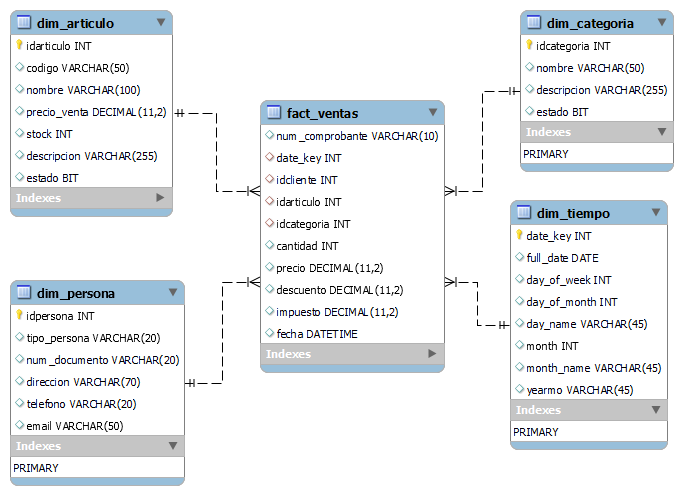

In [5]:
try:
    response = aws_rds_conn.create_db_instance(
                DBInstanceIdentifier=config.get('DWH','DB_INSTANCE_ID'),
                DBName=config.get('DWH', 'DB_NAME'),
                DBInstanceClass='db.t3.micro',
                Engine='postgres',
                MasterUsername=config.get('DWH', 'DB_USER'),
                MasterUserPassword=config.get('DWH', 'DB_PASSWORD'),
                Port=int(config.get('DWH', 'DB_PORT')),
                PubliclyAccessible=True,
                VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
                AllocatedStorage=15
               )
    print(response)
except aws_rds_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print('La instancia ya existe')
except Exception as ex:
    print('Error!! ', ex)
    

{'DBInstance': {'DBInstanceIdentifier': 'ventas-dwh', 'DBInstanceClass': 'db.t3.micro', 'Engine': 'postgres', 'DBInstanceStatus': 'creating', 'MasterUsername': 'postgres_admin', 'DBName': 'dwhpuntoventa', 'AllocatedStorage': 15, 'PreferredBackupWindow': '07:13-07:43', 'BackupRetentionPeriod': 1, 'DBSecurityGroups': [], 'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-011f0a6c313f819e9', 'Status': 'active'}], 'DBParameterGroups': [{'DBParameterGroupName': 'default.postgres16', 'ParameterApplyStatus': 'in-sync'}], 'DBSubnetGroup': {'DBSubnetGroupName': 'default', 'DBSubnetGroupDescription': 'default', 'VpcId': 'vpc-09e5ac0049f317462', 'SubnetGroupStatus': 'Complete', 'Subnets': [{'SubnetIdentifier': 'subnet-002e032543a6bab3c', 'SubnetAvailabilityZone': {'Name': 'us-east-1f'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-075dee9f0bf4b8e81', 'SubnetAvailabilityZone': {'Name': 'us-east-1b'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier':

In [5]:
try:
    instance=aws_rds_conn.describe_db_instances(DBInstanceIdentifier=config.get('DWH','DB_INSTANCE_ID'))
    RDS_HOSTNAMEDWH= instance.get('DBInstances')[0].get('Endpoint').get('Address')
    print(RDS_HOSTNAMEDWH)
except Exception as ex:
    print('Error!!!', ex)

ventas-dwh.crkusmo6c5dz.us-east-1.rds.amazonaws.com


In [6]:
import Arquitectura_DWH_Python
Arquitectura_DWH_Python.DDL_QUERY

'\nCREATE TABLE IF NOT EXISTS dim_tiempo (\n  date_key INT NOT NULL,\n  full_date DATE NULL,\n  day_of_week INT NULL,\n  day_of_month INT NULL,\n  day_name VARCHAR(45) NULL,\n  month INT NULL,\n  month_name VARCHAR(45) NULL,\n  yearmo VARCHAR(45) NULL,\n  PRIMARY KEY (date_key)\n  );\n\n\nCREATE TABLE IF NOT EXISTS dim_persona (\n  idpersona INT NOT NULL,\n  tipo_persona VARCHAR(20) NULL,\n  num_documento VARCHAR(20) NULL,\n  direccion VARCHAR(70) NULL,\n  telefono VARCHAR(20) NULL,\n  email VARCHAR(50) NULL,\n  PRIMARY KEY (idpersona)\n  );\n\n\nCREATE TABLE IF NOT EXISTS dim_articulo (\n  idarticulo INT NOT NULL,\n  codigo VARCHAR(50) NULL,\n  nombre VARCHAR(100) NULL,\n  precio_venta DECIMAL(11,2) NULL,\n  stock INT NULL,\n  descripcion VARCHAR(255) NULL,\n  estado BIT NULL,\n  PRIMARY KEY (idarticulo)\n  );\n\n\nCREATE TABLE IF NOT EXISTS dim_categoria (\n  idcategoria INT NOT NULL,\n  nombre VARCHAR(50) NULL,\n  descripcion VARCHAR(255) NULL,\n  estado BIT NULL,\n  PRIMARY KEY (id

In [7]:
try:
    db_pg_conn = psycopg2.connect(
                    database=config.get('DWH', 'DB_NAME'),
                    user=config.get('DWH', 'DB_USER'),
                    password=config.get('DWH', 'DB_PASSWORD'),
                    host=RDS_HOSTNAMEDWH,
                    port=config.get('DWH', 'DB_PORT')
                )
    cursor = db_pg_conn.cursor()
    cursor.execute(Arquitectura_DWH_Python.DDL_QUERY)
    db_pg_conn.commit()
    print("Base de datos creada exitosamente")
except Exception as ex:
    print('Error!!!', ex)

Base de datos creada exitosamente


### ETL

In [8]:
def obtenerDatosTabla(table_name, driver):
    
    consulta = 'SELECT * FROM '+ table_name
    
    try:
        response = pd.read_sql_query(consulta, driver)
        return response
    except Exception as ex:
        print(ex)

In [9]:
driver = f"""mysql://{config.get('TRANSACC', 'DB_USER')}:{config.get('TRANSACC', 'DB_PASSWORD')}@{RDS_HOSTNAME}:{config.get('TRANSACC', 'DB_PORT')}/{config.get('TRANSACC', 'DB_NAME')}"""

In [9]:
df_categoria = pd.DataFrame(obtenerDatosTabla('categoria',driver))
df_articulo = pd.DataFrame(obtenerDatosTabla('articulo',driver))
df_persona = pd.DataFrame(obtenerDatosTabla('persona',driver))
df_ventas = pd.DataFrame(obtenerDatosTabla('venta',driver))
df_det_venta = pd.DataFrame(obtenerDatosTabla('detalle_venta',driver))

In [10]:
def InsertAPostgres(data_dict, table_name, driver):
    
    df_data=pd.DataFrame.from_records(data_dict)
    
    try:
        response = df_data.to_sql(table_name, driver, index=False, if_exists='append')
        print(f"Se ha insertado {response} nuevos registros")
        #print(f"El error es el to_sql")
    except Exception as ex:
        print(ex)

In [6]:
driverpg = f"""postgresql://{config.get('DWH', 'DB_USER')}:{config.get('DWH', 'DB_PASSWORD')}@{RDS_HOSTNAMEDWH}:{config.get('DWH', 'DB_PORT')}/{config.get('DWH', 'DB_NAME')}"""

### Llenando tabla de DWH Tablas de dimensiones y hechos

In [ ]:
data_categoriadw = []

for indice, categoria in df_categoria.iterrows():
    nueva_categoria = {
        'idcategoria': categoria.iloc[0],
        'nombre':categoria.iloc[1],
        'descripcion':categoria.iloc[2],
        'estado':'1'
    }
    data_categoriadw.append(nueva_categoria)

InsertAPostgres(data_categoriadw, 'dim_categoria', driverpg)

In [ ]:
data_articulodw = []

for indice, articulo in df_articulo.iterrows():
    nuevo_articulo = {
        'idarticulo': articulo.iloc[0],
        'codigo':articulo.iloc[2],
        'nombre':articulo.iloc[3],
        'precio_venta':articulo.iloc[4],
        'stock':articulo.iloc[5],
        'descripcion':articulo.iloc[6],
        'estado':'1'
    }
    data_articulodw.append(nuevo_articulo)
#data_articulodw
InsertAPostgres(data_articulodw, 'dim_articulo', driverpg)

In [ ]:
data_personadw = []

for indice, persona in df_persona.iterrows():
    nueva_persona = {
        'idpersona': persona.iloc[0],
        'tipo_persona':persona.iloc[1],
        'num_documento':persona.iloc[4],
        'direccion':persona.iloc[5],
        'telefono':persona.iloc[6],
        'email':persona.iloc[7]
    }
    data_personadw.append(nueva_persona)

InsertAPostgres(data_personadw, 'dim_persona', driverpg)

In [ ]:
data_tiempodw = []

for indice, tiempo in df_ventas.iterrows():
    nuevo_tiempo = {
        'date_key': int(tiempo.iloc[6].strftime("%Y%m%d")),
        'full_date': tiempo.iloc[6],
        'day_of_week':tiempo.iloc[6].dayofweek,
        'day_of_month':tiempo.iloc[6].day,
        'day_name':tiempo.iloc[6].strftime("%A"),
        'month':tiempo.iloc[6].month,
        'month_name': tiempo.iloc[6].strftime("%B"),
        'yearmo': tiempo.iloc[6].strftime("%Y%m")
    }
    data_tiempodw.append(nuevo_tiempo)
    
#data_tiempodw
InsertAPostgres(data_tiempodw, 'dim_tiempo', driverpg)

In [ ]:
data_factdw = []

df_facts =  df_ventas.merge(df_det_venta, on='idventa', how='inner')

df_facts = df_facts.merge(df_articulo, on='idarticulo', how='inner')

df_facts = df_facts.merge(df_categoria, on='idcategoria', how='inner')


for indice, venta in df_facts.iterrows():
    nuevo_hecho = {
       'num_comprobante': venta.iloc[5],
        'date_key': int(venta.iloc[6].strftime("%Y%m%d")),
        'idcliente':venta.iloc[1],
        'idarticulo':venta.iloc[11],
        'idcategoria':venta.iloc[15],
        'cantidad':venta.iloc[12],
        'precio': venta.iloc[13],
        'descuento': venta.iloc[14],
        'impuesto': venta.iloc[7],
        'fecha': venta.iloc[6]
    }
    data_factdw.append(nuevo_hecho)
    
#data_factdw
InsertAPostgres(data_factdw, 'fact_ventas', driverpg)

### Analytics - Respuesta de las preguntas

In [7]:
engine = create_engine(driverpg)
consulta_ventas = '''SELECT * FROM fact_ventas;'''
ventas = pd.read_sql_query(consulta_ventas, engine)

In [8]:
ventas['Total_ventas'] = ventas['cantidad']*ventas['precio']-(((ventas['cantidad']*ventas['precio'])*ventas['impuesto'])/100)

### 1. Obtener el total de ventas

In [9]:
print(f'Total de ventas: ',ventas['Total_ventas'].sum())

Total de ventas:  153.3083


### 2. Obtener Ventas Totales por categoría

In [10]:
engine = create_engine(driverpg)
consulta_categoria = '''SELECT * FROM dim_categoria;'''
categoria = pd.read_sql_query(consulta_categoria, engine)

total_cat = ventas.merge(categoria, on='idcategoria', how='inner')


In [11]:
df = total_cat[['nombre','Total_ventas']].groupby(by='nombre').sum()
df

,Total_ventas
nombre,
Carnes,42.5634
Congelados,29.6226
Frutas y Verduras,36.4692
Lácteos,22.6850
Panadería,21.9681


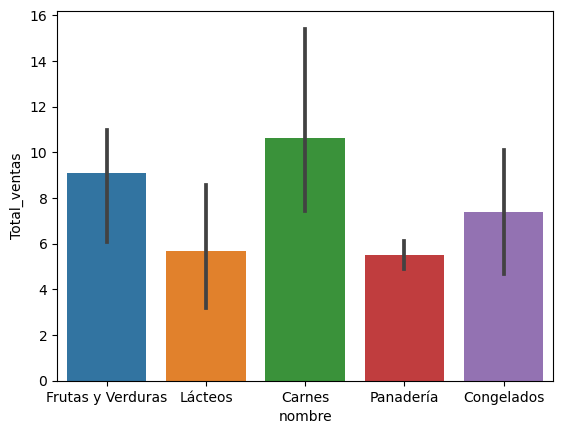

In [12]:
sns.barplot(data=total_cat, x='nombre', y='Total_ventas')
plt.show()

### 3. Top 3 de categorias más vendidas

In [13]:
top3 = df.sort_values(by='Total_ventas', ascending=False)
top3[:3]

,Total_ventas
nombre,
Carnes,42.5634
Frutas y Verduras,36.4692
Congelados,29.6226


### 4. Top 5 clientes gold

In [14]:
engine = create_engine(driverpg)
consulta_persona = '''SELECT * FROM dim_persona;'''
cliente = pd.read_sql_query(consulta_persona, engine)

total_cte = ventas.merge(cliente, left_on='idcliente', right_on='idpersona', how='inner')

In [15]:
df_cte = total_cte[['num_documento','Total_ventas']].groupby(by='num_documento').sum()
top = df_cte.sort_values(by='Total_ventas', ascending=False)
top

,Total_ventas
num_documento,
87654321,40.5822
23456789,32.3769
56789012,29.3434
12345678,27.8706
98765432,23.1352


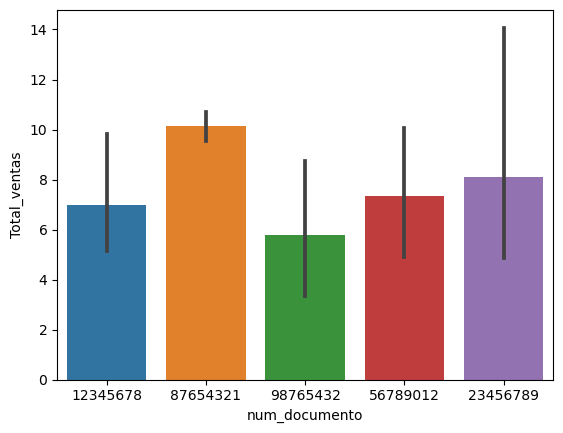

In [16]:
sns.barplot(data=total_cte, x='num_documento', y='Total_ventas')
plt.show()

### 5. Fechas de más venta

In [ ]:
df_fechas = ventas[['fecha', 'Total_ventas']]

In [12]:
top_fechas = df_fechas.groupby(by='fecha').sum()
tp = top_fechas.sort_values(by='Total_ventas', ascending=False)
tp

,Total_ventas
fecha,
2024-03-05,22.4000
2024-03-02,20.3490
2024-03-07,20.2332
2024-03-04,18.8518
2024-03-01,15.9750
2024-03-08,14.3792
2024-03-06,11.8956
2024-03-09,10.4916
2024-03-10,9.9769
